In [2]:
import sys
path_to_pip_installs = "/tmp/test_env"
if path_to_pip_installs not in sys.path:
    sys.path.insert(0, path_to_pip_installs)

import torch
import numpy as np
import os
from backbones.dense_layer import conv2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from dataset_dixon import CreateDatasetSynthesis
from torch.multiprocessing import Process
import torch.distributed as dist
import shutil
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

from utils.EMA import EMA
from train_utils import sample_from_model, sample_posterior, copy_source, broadcast_params, var_func_vp, var_func_geometric, extract, get_time_schedule, get_sigma_schedule, Diffusion_Coefficients, q_sample, q_sample_pairs, Posterior_Coefficients

from backbones.discriminator import Discriminator_large

from backbones.ncsnpp_generator_adagn_feat import NCSNpp
from backbones.ncsnpp_generator_adagn_feat import NCSNpp_adaptive

W0922 14:55:47.218000 800582 torch/utils/cpp_extension.py:118] No CUDA runtime is found, using CUDA_HOME='/home/students/studweilc1/.conda/envs/cornelius_new'
W0922 14:55:47.410000 800582 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W0922 14:55:47.410000 800582 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.
W0922 14:55:47.642000 800582 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W0922 14:55:47.642000 800582 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


module_path = /mnt/ceph/vol_02_home_students/studweilc1/MU-Diff/utils/op


## Parameters

In [3]:
from types import SimpleNamespace

args = SimpleNamespace(
    # Reproducibility
    seed=1024,
    resume=False,

    # Data / images
    image_size=32,
    num_channels=3,
    centered=True,
    use_geometric=False,
    beta_min=0.1,
    beta_max=20.,

    # Denoising model
    num_channels_dae=128,
    n_mlp=3,
    ch_mult=[1, 1, 2, 2, 4, 4],
    num_res_blocks=2,
    attn_resolutions=(16,),
    dropout=0.,
    resamp_with_conv=True,
    conditional=True,
    fir=True,
    fir_kernel=[1, 3, 3, 1],
    skip_rescale=True,
    resblock_type='biggan',
    progressive='none',
    progressive_input='residual',
    progressive_combine='sum',

    embedding_type='positional',
    fourier_scale=16.,
    not_use_tanh=False,

    # Generator & training
    exp='debug',
    input_path='data/my_data',
    output_path='results',
    nz=100,
    num_timesteps=4,

    z_emb_dim=256,
    t_emb_dim=256,
    batch_size=1,   # good for CPU-only
    num_epoch=1200,
    ngf=64,

    lr_g=1.5e-4,
    lr_d=1e-4,
    beta1=0.5,
    beta2=0.9,
    no_lr_decay=False,

    use_ema=False,
    ema_decay=0.9999,

    r1_gamma=0.05,
    lazy_reg=None,

    save_content=True,
    save_content_every=1,
    save_ckpt_every=10,
    lambda_l1_loss=0.5,
    lambda_mask_loss=0.1,

    # DDP (turned into CPU-only single process)
    num_proc_node=1,
    num_process_per_node=1,   # 1 → no GPU parallelism
    node_rank=0,
    local_rank=0,
    master_address='127.0.0.1',
    contrast1='T1',
    contrast2='T2',
    port_num='6021',

    # Derived
    world_size=1,
    global_rank=0,
)

device = "cpu"
batch_size = args.batch_size
nz = args.nz
rank = 0


to_range_0_1 = lambda x: (x + 1.) / 2.
critic_criterian = nn.BCEWithLogitsLoss(reduction='none')




## Data Loading

In [4]:
dataset = CreateDatasetSynthesis(phase="train", input_path=args.input_path)
dataset_val = CreateDatasetSynthesis(phase="val", input_path=args.input_path)

train_sampler = torch.utils.data.distributed.DistributedSampler(dataset,
                                                                num_replicas=args.world_size,
                                                                rank=rank)
data_loader = torch.utils.data.DataLoader(dataset,
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=4,
                                            pin_memory=True,
                                            sampler=train_sampler,
                                            drop_last=True)
val_sampler = torch.utils.data.distributed.DistributedSampler(dataset_val,
                                                                num_replicas=args.world_size,
                                                                rank=rank)
data_loader_val = torch.utils.data.DataLoader(dataset_val,
                                                batch_size=batch_size,
                                                shuffle=False,
                                                num_workers=4,
                                                pin_memory=True,
                                                sampler=val_sampler,
                                                drop_last=True)

val_l1_loss = np.zeros([2, args.num_epoch, len(data_loader_val)])
val_psnr_values = np.zeros([2, args.num_epoch, len(data_loader_val)])
print('train data size:' + str(len(data_loader)))
print('val data size:' + str(len(data_loader_val)))

padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
train data size:950
val data size:71


## Network setup

In [5]:
# override args
exp_path = "results/exp_brats2"
checkpoint_file = os.path.join(exp_path, 'content.pth')
checkpoint = torch.load(checkpoint_file, map_location=device, weights_only=False)
args = checkpoint["args"]

In [6]:

import os, socket, time
import wandb
from dotenv import load_dotenv

load_dotenv()  # reads .env in the working directory
api_key = os.getenv("WANDB_API_KEY")
if api_key:
    wandb.login(key=api_key)

run_name = f"test-cpu-{time.strftime('%Y%m%d-%H%M%S')}"
wandb.init(
    project="mudiff",         # change if you want a different project
    name=run_name,
    config=vars(args),        # logs your full args Namespace
    tags=["cpu", "notebook"],
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/students/studweilc1/.netrc
wandb: Currently logged in as: corneliuswiehl (corneliuswiehl-university-of-tuebingen) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [7]:
# networks performing reverse denoising
gen_diffusive_1 = NCSNpp(args).to(device)
gen_diffusive_2 = NCSNpp_adaptive(args).to(device)

args.num_channels = 1
att_conv = conv2d(64 * 8, 1, 1, padding=0).cpu()

disc_diffusive_2 = Discriminator_large(nc=2, ngf=args.ngf,
                                        t_emb_dim=args.t_emb_dim,
                                        act=nn.LeakyReLU(0.2)).to(device)

optimizer_disc_diffusive_2 = optim.Adam(disc_diffusive_2.parameters(), lr=args.lr_d, betas=(args.beta1, args.beta2))

optimizer_gen_diffusive_1 = optim.Adam(gen_diffusive_1.parameters(), lr=args.lr_g, betas=(args.beta1, args.beta2))

optimizer_gen_diffusive_2 = optim.Adam(gen_diffusive_2.parameters(), lr=args.lr_g, betas=(args.beta1, args.beta2))

if args.use_ema:
    optimizer_gen_diffusive_1 = EMA(optimizer_gen_diffusive_1, ema_decay=args.ema_decay)
    optimizer_gen_diffusive_2 = EMA(optimizer_gen_diffusive_2, ema_decay=args.ema_decay)

scheduler_gen_diffusive_1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_gen_diffusive_1, args.num_epoch,
                                                                        eta_min=1e-5)
scheduler_gen_diffusive_2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_gen_diffusive_2, args.num_epoch,
                                                                        eta_min=1e-5)

scheduler_disc_diffusive_2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_disc_diffusive_2, args.num_epoch,
                                                                        eta_min=1e-5)


exp = args.exp

output_path = args.output_path

exp_path = os.path.join(output_path, exp)

coeff = Diffusion_Coefficients(args, device)
pos_coeff = Posterior_Coefficients(args, device)
T = get_time_schedule(args, device)

## Network resume

In [8]:
global_step, epoch, init_epoch = 0, 0, 0

def _strip_module_prefix(sd):
    # remove a single leading "module." if present
    return { (k[7:] if k.startswith("module.") else k): v for k, v in sd.items() }

In [9]:
exp_path = "results/exp_brats2"
checkpoint_file = os.path.join(exp_path, 'content.pth')
checkpoint = torch.load(checkpoint_file, map_location=device, weights_only=False)
init_epoch = checkpoint['epoch']
epoch = init_epoch
sd1 = _strip_module_prefix(checkpoint['gen_diffusive_1_dict'])
sd2 = _strip_module_prefix(checkpoint['gen_diffusive_2_dict'])
gen_diffusive_1.load_state_dict(sd1)  # keep strict=True by default
gen_diffusive_2.load_state_dict(sd2)

optimizer_gen_diffusive_1.load_state_dict(checkpoint['optimizer_gen_diffusive_1'])
scheduler_gen_diffusive_1.load_state_dict(checkpoint['scheduler_gen_diffusive_1'])
optimizer_gen_diffusive_2.load_state_dict(checkpoint['optimizer_gen_diffusive_2'])
scheduler_gen_diffusive_2.load_state_dict(checkpoint['scheduler_gen_diffusive_2'])

sdD = _strip_module_prefix(checkpoint['disc_diffusive_2_dict'])
disc_diffusive_2.load_state_dict(sdD)
optimizer_disc_diffusive_2.load_state_dict(checkpoint['optimizer_disc_diffusive_2'])
scheduler_disc_diffusive_2.load_state_dict(checkpoint['scheduler_disc_diffusive_2'])

global_step = checkpoint['global_step']
print("=> loaded checkpoint (epoch {})"
        .format(checkpoint['epoch']))

=> loaded checkpoint (epoch 21)


## Training

In [10]:
epoch = init_epoch

for iteration, (x1, x2, x3, x4) in enumerate(data_loader):
    if iteration > 25:
        break


/tmp/test_env/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


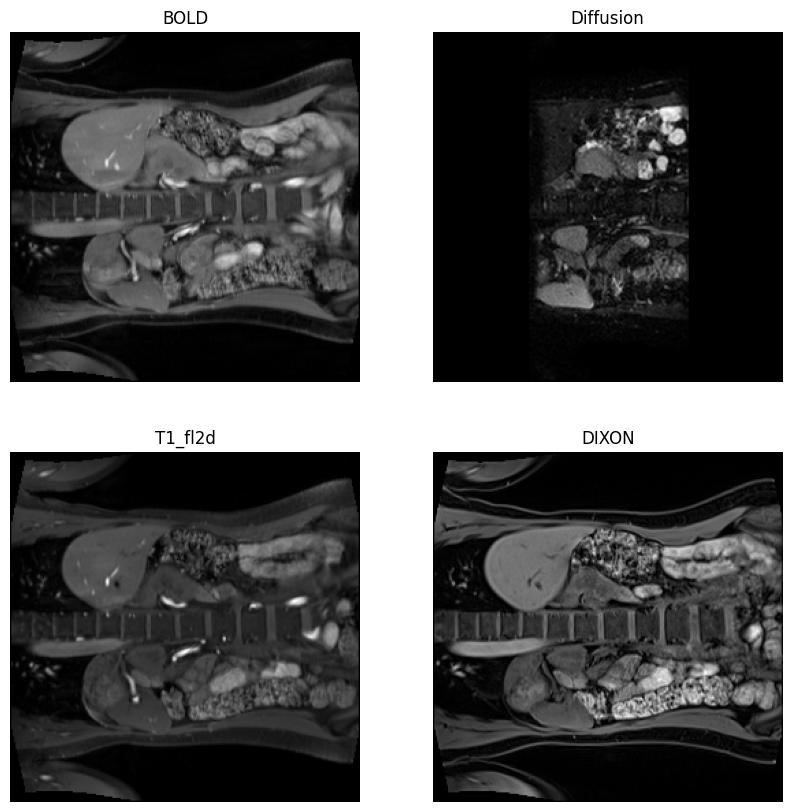

In [11]:
def plot_slices(x1,x2,x3,x4, figsize=(12,3)):
    fig, axs = plt.subplots(2,2, figsize=figsize)
    axs[0,0].imshow(x1[0,0].cpu(), cmap='gray')
    axs[0,0].axis('off')
    axs[0,0].set_title('BOLD')
    axs[0,1].imshow(x2[0,0].cpu(), cmap='gray')
    axs[0,1].axis('off')
    axs[0,1].set_title('Diffusion')
    axs[1,0].imshow(x3[0,0].cpu(), cmap='gray')
    axs[1,0].axis('off')
    axs[1,0].set_title('T1_fl2d')
    axs[1,1].imshow(x4[0,0].cpu(), cmap='gray')
    axs[1,1].axis('off')
    axs[1,1].set_title('DIXON')
    plt.show()

def plot_images(list_of_images):
    # first check that images have shape (256,256)
    n = len(list_of_images)
    # if torch types conbert to numpy
    for i in range(n):
        if isinstance(list_of_images[i], torch.Tensor):
            list_of_images[i] = list_of_images[i].detach().numpy()
    fig, axs = plt.subplots(1,n, figsize=(3*n,3))
    for i in range(n):
        axs[i].imshow(list_of_images[i][0,0], cmap='gray')
        axs[i].axis('off')
    plt.show()

plot_slices(x1,x2,x3,x4, figsize=(10,10))

#### Err Disc Real

t2: tensor([3])


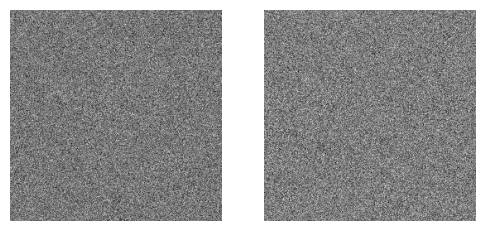

In [12]:
for p in disc_diffusive_2.parameters():
    p.requires_grad = True

disc_diffusive_2.zero_grad()
# sample from p(x_0)
cond_data1 = x1.to(device, non_blocking=True)
cond_data2 = x2.to(device, non_blocking=True)
cond_data3 = x3.to(device, non_blocking=True)
real_data = x4.to(device, non_blocking=True)

t2 = torch.randint(0, args.num_timesteps, (real_data.size(0),), device=device)
print("t2:", t2)

# x2_t is image at timestamp t, x2_tp1 is image (noisier) at timestamp t+1
x2_t, x2_tp1 = q_sample_pairs(coeff, real_data, t2)
x2_t.requires_grad = True

plot_images([x2_t, x2_tp1])

# train discriminator with real
# The goal of disc_diffusive_2 is to act as a critic for the reverse diffusion process
D2_real, _ = disc_diffusive_2(x2_t, t2, x2_tp1.detach())

errD2_real2 = F.softplus(-D2_real)
errD2_real2 = errD2_real2.mean()
errD_real2 = errD2_real2
errD_real2.backward(retain_graph=True)

In [13]:
if args.lazy_reg is None:

    grad2_real = torch.autograd.grad(
        outputs=D2_real.sum(), inputs=x2_t, create_graph=True
    )[0]
    grad2_penalty = (
            grad2_real.view(grad2_real.size(0), -1).norm(2, dim=1) ** 2
    ).mean()

    grad_penalty2 = args.r1_gamma / 2 * grad2_penalty
    grad_penalty2.backward()
else:
    if global_step % args.lazy_reg == 0:
        grad2_real = torch.autograd.grad(
            outputs=D2_real.sum(), inputs=x2_t, create_graph=True
        )[0]
        grad2_penalty = (
                grad2_real.view(grad2_real.size(0), -1).norm(2, dim=1) ** 2
        ).mean()

        grad_penalty2 = args.r1_gamma / 2 * grad2_penalty
        grad_penalty2.backward()

#### Err Disc Fake

In [14]:
# Used by the generators to make their reverse step stochastic
latent_z2 = torch.randn(batch_size, nz, device=device)

# Predict clean image from x2_tp1
# x2_tp1.detach() ensures gradients don’t flow back into the forward-diffusion sampler
# Generator G1’s prediction of the clean image x0
x2_0_predict_diff_g1 = gen_diffusive_1(x2_tp1.detach(), cond_data1, cond_data2, cond_data3, t2, latent_z2)

x2_0_predict_diff_g2 = gen_diffusive_2(x2_tp1.detach(), cond_data1, cond_data2, cond_data3, t2, latent_z2,
                                        x2_0_predict_diff_g1[:, [0], :])

# sample from posterior p(x_t | x_0, x_{t+1})
x2_pos_sample_g1 = sample_posterior(pos_coeff, x2_0_predict_diff_g1[:, [0], :], x2_tp1, t2)

x2_pos_sample_g2 = sample_posterior(pos_coeff, x2_0_predict_diff_g2[:, [0], :], x2_tp1, t2)

output2_g1, _ = disc_diffusive_2(x2_pos_sample_g1, t2, x2_tp1.detach())

output2_g2, _ = disc_diffusive_2(x2_pos_sample_g2, t2, x2_tp1.detach())

errD2_fake2_g1 = (F.softplus(output2_g1)).mean()

errD2_fake2_g2 = (F.softplus(output2_g2)).mean()

errD_fake2 = errD2_fake2_g1 + errD2_fake2_g2
errD_fake2.backward()

optimizer_disc_diffusive_2.step()

In [15]:
wandb.log({
    "loss/D/real": errD_real2.item(),
    "loss/D/fake_g1": errD2_fake2_g1.item(),
    "loss/D/fake_g2": errD2_fake2_g2.item(),
    "lr/D": optimizer_disc_diffusive_2.param_groups[0]["lr"],
}, step=global_step)

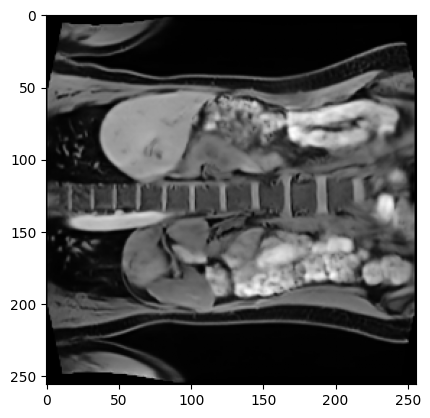

In [16]:
plt.imshow(x2_0_predict_diff_g1.detach()[0,0,:,:], cmap='gray')

#### Err Generators

In [17]:
for p in disc_diffusive_2.parameters():
    p.requires_grad = False

cond_data1 = x1.to(device, non_blocking=True)
cond_data2 = x2.to(device, non_blocking=True)
cond_data3 = x3.to(device, non_blocking=True)
real_data = x4.to(device, non_blocking=True)

gen_diffusive_1.zero_grad()
gen_diffusive_2.zero_grad()

t2 = torch.randint(0, args.num_timesteps, (real_data.size(0),), device=device)

# sample x_t and x_tp1
x2_t, x2_tp1 = q_sample_pairs(coeff, real_data, t2)

latent_z2 = torch.randn(batch_size, nz, device=device)

x2_0_predict_diff_g1 = gen_diffusive_1(x2_tp1.detach(), cond_data1, cond_data2, cond_data3, t2, latent_z2)

x2_0_predict_diff_g2 = gen_diffusive_2(x2_tp1.detach(), cond_data1, cond_data2, cond_data3, t2, latent_z2,
                                        x2_0_predict_diff_g1[:, [0], :])

# sampling q(x_t | x_0_predict, x_t+1)
x2_pos_sample_g1 = sample_posterior(pos_coeff, x2_0_predict_diff_g1[:, [0], :], x2_tp1, t2)

x2_pos_sample_g2 = sample_posterior(pos_coeff, x2_0_predict_diff_g2[:, [0], :], x2_tp1, t2)

# D output for fake sample x_pos_sample
output2_g1, att_feat_g1 = disc_diffusive_2(x2_pos_sample_g1, t2, x2_tp1.detach())

output2_g2, att_feat_g2 = disc_diffusive_2(x2_pos_sample_g2, t2, x2_tp1.detach())

att_map_g1 = torch.sigmoid(att_conv(att_feat_g1))
att_map_g1 = F.interpolate(att_map_g1, size=(256, 256), mode='bilinear', align_corners=False)

att_map_g2 = torch.sigmoid(att_conv(att_feat_g2))
att_map_g2 = F.interpolate(att_map_g2, size=(256, 256), mode='bilinear', align_corners=False)

mask_loss_1 = (att_map_g2 * critic_criterian(x2_pos_sample_g1, torch.sigmoid(x2_pos_sample_g2))).mean()
mask_loss_2 = (att_map_g1 * critic_criterian(x2_pos_sample_g2, torch.sigmoid(x2_pos_sample_g1))).mean()

mask_loss = mask_loss_1 + mask_loss_2

errG2 = F.softplus(-output2_g1)
errG2 = errG2.mean()

errG4 = F.softplus(-output2_g2)
errG4 = errG4.mean()

errG_adv = errG2 + errG4

errG1_2_L1 = F.l1_loss(x2_0_predict_diff_g1[:, [0], :], real_data)

errG2_2_L1 = F.l1_loss(x2_0_predict_diff_g2[:, [0], :], real_data)

errG_L1 = errG1_2_L1 + errG2_2_L1

errG = errG_adv + (args.lambda_l1_loss * errG_L1) + (args.lambda_mask_loss * mask_loss)

errG.backward()
optimizer_gen_diffusive_1.step()
optimizer_gen_diffusive_2.step()

In [18]:
wandb.log({
    "loss/G/adv_g1": errG2.item(),
    "loss/G/adv_g2": errG4.item(),
    "loss/G/adv_total": errG_adv.item(),
    "loss/G/L1_g1": errG1_2_L1.item(),
    "loss/G/L1_g2": errG2_2_L1.item(),
    "loss/G/L1_total": errG_L1.item(),
    "loss/G/mask": mask_loss.item(),
    "loss/G/total": errG.item(),
    "lr/G1": optimizer_gen_diffusive_1.param_groups[0]["lr"],
    "lr/G2": optimizer_gen_diffusive_2.param_groups[0]["lr"],
}, step=global_step)

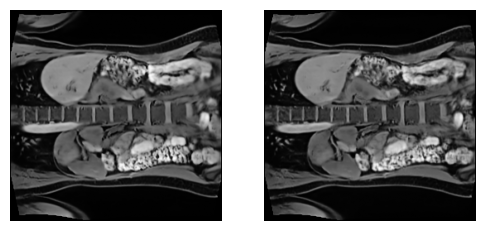

In [19]:
plot_images([x2_0_predict_diff_g1, x2_0_predict_diff_g2])

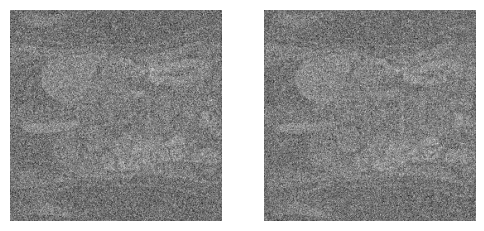

In [20]:
plot_images([x2_pos_sample_g1, x2_pos_sample_g2])

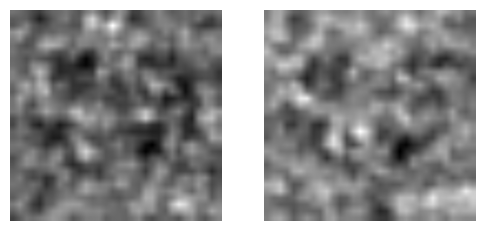

In [21]:
plot_images([att_map_g1, att_map_g2])

## Evaluate

#### On train

/tmp/ipykernel_800582/2642721013.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[2].imshow(np.abs(real_data[0,0].cpu() - fake_sample[0,0].cpu()), cmap='gray')


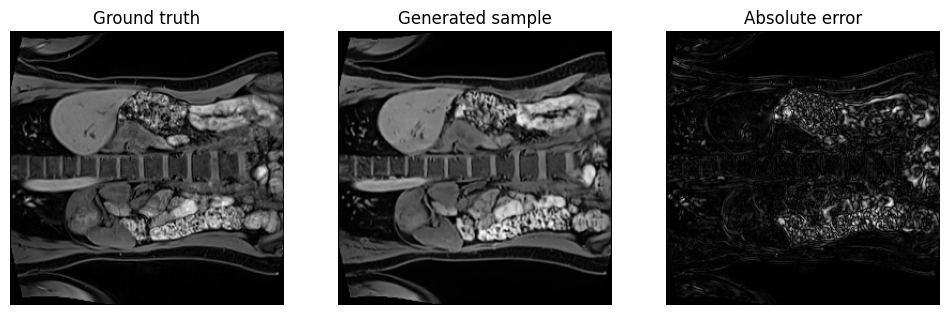

L1:  0.2450035
PSNR:  21.14240528906773


In [22]:
x2_t = torch.randn_like(real_data)
fake_sample = sample_from_model(pos_coeff, gen_diffusive_1, cond_data1, gen_diffusive_2, cond_data2,
                                cond_data3,
                                args.num_timesteps, x2_t, T, args)


fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(real_data[0,0].cpu(), cmap='gray')
ax[0].set_title('Ground truth')
ax[0].axis('off')
ax[1].imshow(fake_sample[0,0].cpu(), cmap='gray')
ax[1].set_title('Generated sample')
ax[1].axis('off')
ax[2].imshow(np.abs(real_data[0,0].cpu() - fake_sample[0,0].cpu()), cmap='gray')
ax[2].set_title('Absolute error')
ax[2].axis('off')
plt.show()   

# calculate L1 and PSNR
fake_sample = to_range_0_1(fake_sample).detach().cpu().numpy()
fake_sample = fake_sample / fake_sample.mean()
real_data = to_range_0_1(real_data).detach().cpu().numpy()
real_data = real_data / real_data.mean()

print("L1: ", abs(fake_sample - real_data).mean())

print("PSNR: ", psnr(real_data, fake_sample, data_range=real_data.max()))

#### On Val

In [23]:
for iteration, (x1_val, x2_val, x3_val, x4_val) in enumerate(data_loader_val):
    if iteration > 10:
        break
cond_data1_val = x1_val.to(device, non_blocking=True)
cond_data2_val = x2_val.to(device, non_blocking=True)
cond_data3_val = x3_val.to(device, non_blocking=True)
real_data_val = x4_val.to(device, non_blocking=True)

x_t = torch.randn_like(real_data_val)

fake_sample_val = sample_from_model(pos_coeff, gen_diffusive_1, cond_data1_val, gen_diffusive_2,
                                    cond_data2_val,
                                    cond_data3_val,
                                    args.num_timesteps, x_t, T, args)

# diffusion steps
fake_sample_val = to_range_0_1(fake_sample_val);
fake_sample_val = fake_sample_val / fake_sample_val.mean()
real_data_val = to_range_0_1(real_data_val);
real_data_val = real_data_val / real_data_val.mean()

fake_sample_val = fake_sample_val.cpu().numpy()
real_data_val = real_data_val.cpu().numpy()
print("L1: ", abs(fake_sample_val - real_data_val).mean())

print("PSNR: ", psnr(real_data_val, fake_sample_val, data_range=real_data_val.max()))


L1:  0.24399574
PSNR:  20.828103216991487


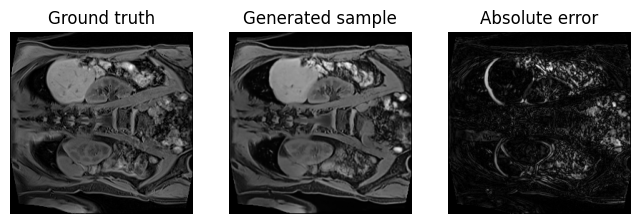

In [24]:
fig, ax = plt.subplots(1,3, figsize=(8,4))
ax[0].imshow(real_data_val[0,0], cmap='gray')
ax[0].set_title('Ground truth')
ax[0].axis('off')
ax[1].imshow(fake_sample_val[0,0], cmap='gray')
ax[1].set_title('Generated sample')
ax[1].axis('off')
ax[2].imshow(np.abs(real_data_val[0,0] - fake_sample_val[0,0]), cmap='gray')
ax[2].set_title('Absolute error')
ax[2].axis('off')
plt.show()